## Importing json file and preproccessing data

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
# Importing SVM utilities
from Utils.SVM import SVC_model, dimension_reduction_by_PCA
# Importing json conversion to data frame function
from Utils.dataframes import json_to_dataframe, Category_encode
from Utils.plots import plotting_PCA_SVC, averaging_plot

TRITONE_DATA_PATH= "../Files/clean_tri_tone_synthetic.json"

In [13]:
jaccard_df, tones = json_to_dataframe(TRITONE_DATA_PATH)

# Categorically encoding negative: 0, neutral: 1,  positive: 2
tones = Category_encode(tones)

## SVM Implementation

In [14]:
X_jacc_words = jaccard_df.to_numpy()

Y_label = tones.to_numpy()

# SVC_model imported from Utils.SVM
print(SVC_model(X_jacc_words, Y_label, 0.3))

0.9977777777777778


## PCA

In [15]:
pca_X = dimension_reduction_by_PCA(X_jacc_words, 4)
print(SVC_model(pca_X, tones))

0.9977777777777778


## Plotting PCA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


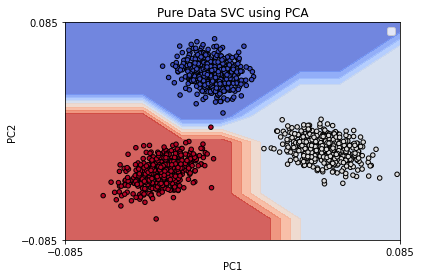

In [18]:
plotting_PCA_SVC(pca_X, Y_label, first_c = 1, second_c = 2)

## Cross Contamination

In [19]:
cross_df = pd.read_csv('../Files/cross-contamination.csv')
y_label = pd.DataFrame(cross_df['Tone'])
t = pd.Categorical(y_label['Tone'])
y_label['Tone'] = t.codes
y = y_label.to_numpy()

cross_df = cross_df.drop(columns=['Tone'])
X_cross = cross_df.to_numpy()

In [20]:
pca_cross = dimension_reduction_by_PCA(X_cross, 4)
SVC_model(pca_cross, y_label)

0.9966666666666667

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


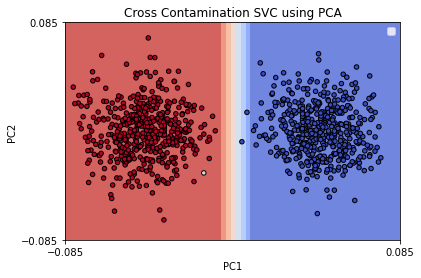

In [21]:
plotting_PCA_SVC(pca_cross, y, first_c = 1, second_c = 2, title = "Cross Contamination SVC using PCA")

Support Vector Classifier (SVC) is a generalized classification model that is an extension of the maximal marginal classifier. A Support Vector Machine is an extension of the SVC to accomodate non-linear boundaries. SVM's seperate the data by finding the optimal seperating hyperplane, which is the hyplane that is furthest from the training observation. The difference between SVC and SVM, is allwoing observations to cross the hyperplane. In our work, we applied SVC's becuase we want to classify if a sentence is negative, positive, and neurtal and find the best hyperplane. However, as we contaminate and add more noise to our data we apply SVM's to allow the overlap of data points. What we want is to observe and achieve how well our accuracy becomes after large amount of noise and cross contamination, and what can be explained from these results. We have show two plots on our pure data and cross contaminated data. 

## Incrementing the feature set by 10% and running 10 test to find its average accuracy and standard deviation 

In [2]:
# Seperate feature and labels
pure_df, tones = json_to_dataframe(TRITONE_DATA_PATH)

# Categorically encoding negative: 0, neutral: 1,  positive: 2
tones = Category_encode(tones)

In [3]:
inc_10 = [0.10, 0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
acc_score = []
for fraction in inc_10: 
    curr_acc_list = []
    for i in range(10):
        df = pure_df.sample(frac= fraction, axis='columns')
        curr_acc_list.append(SVC_model(df, tones))
    acc_score.append(curr_acc_list)

acc = np.array(acc_score).T


accuracy_df = pd.DataFrame(acc, columns=["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"])

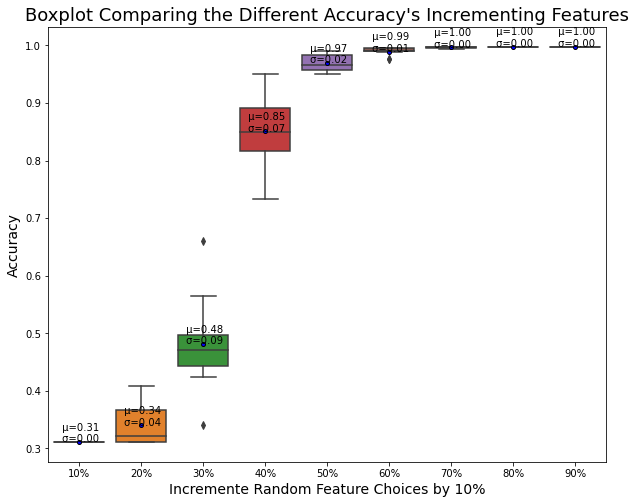

In [4]:
averaging_plot(accuracy_df, x_label="Incremente Random Feature Choices by 10%", title="Boxplot Comparing the Different Accuracy's Incrementing Features")